In [84]:
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ase import io, Atoms, Atom
from pmutt.statmech import StatMech, trans, vib, rot, elec
from pmutt.constants import kb, Na


# interactive plots
%matplotlib widget

In [51]:
KB_KCAL: float = kb("kcal/K")
AVOGADRO: float = Na

KB_KCAL_MOL: float = KB_KCAL * AVOGADRO

print(KB_KCAL * AVOGADRO)

0.001985875020917578


## Sorted according SO-ZORA

In [8]:
# working_directory = Path("/home/danian/hg2w/calculaT/ThermoChemistry/structures")
working_directory = Path.cwd() / "../structures/sozora/"

if not working_directory.exists():
    raise ValueError("The working directory does not exist.")

print(working_directory)

/home/edison/repositories/ThermoChemistry/jupyter/../structures/sozora


In [9]:
list_file_adf = glob(str(working_directory) + '/*.out')
energies_file_adf = working_directory / ('energies.txt')

if not energies_file_adf.exists():
    raise ValueError("The energies file does not exist.")

if not list_file_adf:
    raise ValueError("The list of ADF files does not exist.")

## Reading Coordinates and Frequencies from ADF.2013

In [10]:
find_lines_adf = {}
for file_adf in list_file_adf:
    read_file_adf = Path(file_adf).read_text()

    """ Lines to read the geometry in ADF.2013 """
    start_line_geom = None
    last_line_geom = None
    start_line_freq = None
    last_line_freq = None
    for count, line in enumerate(read_file_adf.split('\n')):

        if line == "                                            *  F R E Q U E N C I E S  *":
            start_line_geom = count + 11
        elif line == " Atomic Masses:":
            last_line_geom = count - 4
        elif line == " List of All Frequencies:":
            start_line_freq = count + 9
        elif line == " Statistical Thermal Analysis  ***  ideal gas assumed  ***":
            last_line_freq = count - 4
        elif start_line_geom and last_line_geom and start_line_freq and last_line_freq:

            break
    find_lines_adf[Path(file_adf).name] = [start_line_geom, last_line_geom, start_line_freq, last_line_freq]


In [11]:
geoms_systems = {}
freqs_systems = {}
energies_systems = {}
for file_adf in list_file_adf:
    with open(Path(file_adf), 'r') as f_adf:
        file_content = f_adf.readlines()

        """Atoms object with ase.Atoms"""
        last_line_geom = find_lines_adf[Path(file_adf).name][1]
        start_line_geom = find_lines_adf[Path(file_adf).name][0]
        lines_geom = last_line_geom - start_line_geom
        coord_system = []
        for i in range(lines_geom):
            line = file_content[start_line_geom + i].split()
            coord_system.append(Atom(line[1], (line[5], line[6], line[7])))
        geoms_systems[Path(file_adf).name] = Atoms(coord_system)

        """Frequencies"""
        last_line_freq = find_lines_adf[Path(file_adf).name][3]
        start_line_freq = find_lines_adf[Path(file_adf).name][2]
        lines_freq = last_line_freq - start_line_freq
        freq_system = []
        for i in range(lines_freq):
            line = file_content[start_line_freq + i].split()
            if float(line[0]) > 20.0:
                freq_system.append(float(line[0]))
        freqs_systems[Path(file_adf).name] = freq_system

    """Energies from ADF.2013 in Ev"""
    with open(energies_file_adf, 'r') as f_energies:
        stop = False
        while stop == False:
            line = f_energies.readline().split()
            if line[0] == Path(file_adf).with_suffix('').name:
                energies_systems[Path(file_adf).name] = float(line[1])
                stop = True

In [12]:
translation = {}
vibration = {}
rotation = {}
electronic = {}
for count, file_adf in enumerate(list_file_adf):
    name_file = Path(file_adf).name

    '''Translational'''
    translation[name_file] = trans.FreeTrans(n_degrees=3, atoms=geoms_systems[name_file])

    '''Vibrational'''
    vibration[name_file] = vib.HarmonicVib(vib_wavenumbers=freqs_systems[name_file]) #cm^-1

    '''Rotational'''
    rotation[name_file] = rot.RigidRotor(symmetrynumber=1, atoms=geoms_systems[name_file]) #simmetry point C1

    '''Electronic'''
    electronic[name_file] = elec.GroundStateElec(potentialenergy=float(energies_systems[name_file]), spin=0) #Ev


In [13]:
statmech = {}
for file_adf in list_file_adf:
    name_file = Path(file_adf).name
    name = Path(file_adf).with_suffix('').name
    '''StatMech Initialization'''
    statmech[name_file] = StatMech(name=name,
                            trans_model=translation[name_file],
                            vib_model=vibration[name_file],
                            rot_model=rotation[name_file],
                            elec_model=electronic[name_file])

In [14]:
print('systems     H[kcal/mol]    S[kcal/mol/K]    G[kcal/mol]     T: 298.15 K')
for file_adf in list_file_adf:
    name_file = Path(file_adf).name
    H_statmech = statmech[name_file].get_H(T=298.15, units='kcal/mol')
    S_statmech = statmech[name_file].get_S(T=298.15, units='kcal/mol/K')
    G_statmech = statmech[name_file].get_G(T=298.15, units='kcal/mol')
    print(f"{name_file}:  {H_statmech:.3f}      {S_statmech:.3f}       {G_statmech:.3f}")
    # print(f'H_w6s1(T=298.15) = {H_statmech:.3f} kcal/mol')
    # print(f'S_w6s1(T=298.15) = {S_statmech:.3f} kcal/mol/K')
    # print(f'G_w6s1(T=298.15) = {G_statmech:.3f} kcal/mol')

systems     H[kcal/mol]    S[kcal/mol/K]    G[kcal/mol]     T: 298.15 K
w4s4.out:  -26361.056      0.116       -26395.700
w5s10.out:  -26702.474      0.124       -26739.555
w3s1.out:  -26028.630      0.093       -26056.486
w6s2.out:  -27059.177      0.123       -27095.863
w3s3.out:  -25993.364      0.095       -26021.616
w5s8.out:  -26698.493      0.132       -26737.733
w4s2.out:  -26376.855      0.107       -26408.837
w5s4.out:  -26719.393      0.116       -26753.917
w2s1.out:  -25668.161      0.077       -25691.234
w6s13.out:  -27042.765      0.135       -27082.944
w6s10.out:  -27049.573      0.130       -27088.411
w6s1.out:  -27061.676      0.126       -27099.293
w4s3.out:  -26370.771      0.104       -26401.658
w6s6.out:  -27054.815      0.133       -27094.556
w5s7.out:  -26705.714      0.115       -26740.100
w5s1.out:  -26722.982      0.113       -26756.550
w4s1.out:  -26380.740      0.097       -26409.611
w6s5.out:  -27056.559      0.131       -27095.725
w6s7.out:  -27052.128    

In [115]:
initital_temperature = 1
final_temperature = 500
step_temperature = 1

In [152]:

thermochemistry_per_temperature = {}

for temperature in range(initital_temperature, final_temperature, step_temperature):
    thermo_data = {
        'system': [],
        "H[kcal/mol]": [], 
        "S[kcal/mol/K]": [], 
        "G[kcal/mol]": [],
    }

    for file_adf in list_file_adf:

        name_file = Path(file_adf).name

        H_statmech = statmech[name_file].get_H(T=temperature, units='kcal/mol')
        S_statmech = statmech[name_file].get_S(T=temperature, units='kcal/mol/K')
        G_statmech = statmech[name_file].get_G(T=temperature, units='kcal/mol')

        thermo_data['system'].append(Path(file_adf).stem)
        thermo_data['H[kcal/mol]'].append(H_statmech)
        thermo_data['S[kcal/mol/K]'].append(S_statmech)
        thermo_data['G[kcal/mol]'].append(G_statmech)

    thermochemistry_per_temperature[temperature] = pd.DataFrame(thermo_data).sort_values(by='system', ascending=True).reset_index(drop=True)


In [153]:
thermochemistry_per_temperature[100][thermochemistry_per_temperature[100]['system'].str.startswith('w4s')]

,system,H[kcal/mol],S[kcal/mol/K],G[kcal/mol]
5,w4s1,-26386.324686,0.067506,-26393.075301
6,w4s2,-26383.064958,0.074501,-26390.515101
7,w4s3,-26376.871117,0.071466,-26384.017673
8,w4s4,-26368.036184,0.079284,-26375.964605


In [162]:


max_number_of_waters = 6

relative_population = {}


for temperature in range(initital_temperature, final_temperature, step_temperature):
    for water in range(1, max_number_of_waters + 1):

        reference_system = f'w{water}s1'

        H_reference = float(
            thermochemistry_per_temperature[temperature][
            thermochemistry_per_temperature[temperature]['system'] == reference_system
            ]['H[kcal/mol]']
        )

        H_values = thermochemistry_per_temperature[temperature][
            thermochemistry_per_temperature[temperature]['system'].str.startswith(reference_system[:-1])
            ]['H[kcal/mol]']


        delta_H = H_values - H_reference 

        total_delta_H = np.exp(-delta_H / KB_KCAL_MOL / temperature).sum()


        population_delta_H = np.exp(-delta_H / KB_KCAL_MOL / temperature) / total_delta_H

        relative_population[reference_system[:-2]] = {
            {temperature: population_delta_H}
        }


        # print(H_values)
        print(population_delta_H)

        break
    break



19    9.309547e-21
20    1.799751e-12
21    4.677709e-12
22    6.372976e-10
23    8.610614e-08
24    2.831920e-01
25    1.186453e-12
26    2.520497e-12
27    2.346026e-04
28    7.165733e-01
29    2.118355e-19
30    4.989948e-19
31    2.990352e-19
32    1.873339e-19
33    1.081991e-18
34    1.489269e-17
35    3.299347e-16
36    3.787270e-14
37    9.494720e-14
38    1.051353e-12
Name: H[kcal/mol], dtype: float64


In [ ]:

    H_reference_w1s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w1s1'
        ]['H[kcal/mol]']
    H_reference_w2s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w2s1'
        ]['H[kcal/mol]']
    H_reference_w3s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w3s1'
        ]['H[kcal/mol]']
    H_reference_w4s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w4s1'
        ]['H[kcal/mol]']
    H_reference_w5s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w5s1'
        ]['H[kcal/mol]']
    H_reference_w6s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w6s1'
        ]['H[kcal/mol]']


    S_reference_w3s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w3s1'
        ]['S[kcal/mol/K]']
    S_reference_w4s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w4s1'
        ]['S[kcal/mol/K]']
    S_reference_w5s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w5s1'
        ]['S[kcal/mol/K]']
    S_reference_w6s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w6s1'
        ]['S[kcal/mol/K]']

    G_reference_w3s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w3s1'
        ]['G[kcal/mol]']
    G_reference_w4s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w4s1'
        ]['G[kcal/mol]']
    G_reference_w5s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w5s1'
        ]['G[kcal/mol]']
    G_reference_w6s1 = thermochemistry_per_temperature[temperature][
        thermochemistry_per_temperature[temperature]['system'] == 'w6s1'
        ]['G[kcal/mol]']

In [104]:

absolute_thermochemical_results = {}

for file_adf in list_file_adf:

    name_file = Path(file_adf).name

    absolute_thermochemical_results[Path(file_adf).stem] = {}

    thermo_data = {
        'temperature[K]': [],
        "H[kcal/mol]": [], 
        "S[kcal/mol/K]": [], 
        "G[kcal/mol]": [],
    }

    for temperature in range(1, 500, 1):

        H_statmech = statmech[name_file].get_H(T=temperature, units='kcal/mol')
        S_statmech = statmech[name_file].get_S(T=temperature, units='kcal/mol/K')
        G_statmech = statmech[name_file].get_G(T=temperature, units='kcal/mol')

        thermo_data['temperature[K]'].append(temperature)
        thermo_data['H[kcal/mol]'].append(H_statmech)
        thermo_data['S[kcal/mol/K]'].append(S_statmech)
        thermo_data['G[kcal/mol]'].append(G_statmech)

    absolute_thermochemical_results[Path(file_adf).stem] = pd.DataFrame(thermo_data)


In [105]:
absolute_thermochemical_results['w6s1'].tail()

,temperature[K],H[kcal/mol],S[kcal/mol/K],G[kcal/mol]
494,495,-27050.532374,0.154614,-27127.066251
495,496,-27050.470163,0.154739,-27127.220927
496,497,-27050.407901,0.154865,-27127.375730
497,498,-27050.345590,0.154990,-27127.530657
498,499,-27050.283229,0.155115,-27127.685710


In [70]:
thermochemical_results = absolute_thermochemical_results['w6s20.out'] - absolute_thermochemical_results['w6s1.out']

thermochemical_results['temperature[K]'] = absolute_thermochemical_results['w6s1.out']['temperature[K]']

thermochemical_results.rename(
    columns={
        'temperature[K]': 'T[K]',
        "H[kcal/mol]": "DH[kcal/mol]",
        "S[kcal/mol/K]": "DS[kcal/mol/K]",
        "G[kcal/mol]": "DG[kcal/mol]",
        }, 
    inplace=True, 
    errors='raise',
    )
    
thermochemical_results.head()

,T[K],DH[kcal/mol],DS[kcal/mol/K],DG[kcal/mol]
0,1,2.067010,-0.002733,2.069743
1,2,2.067010,-0.002733,2.072476
2,3,2.067014,-0.002732,2.075209
3,4,2.067044,-0.002723,2.077938
4,5,2.067140,-0.002702,2.080651


In [76]:
# relative_population = thermochemical_results['T[K]', 'DG[kcal/mol]'] #.apply(lambda x, y: np.exp(-y/KB_KCAL_MOL/x))

relative_population = np.exp(-thermochemical_results['DG[kcal/mol]'] / KB_KCAL_MOL / thermochemical_results['T[K]'])

relative_population.max()

0.40502719645672675

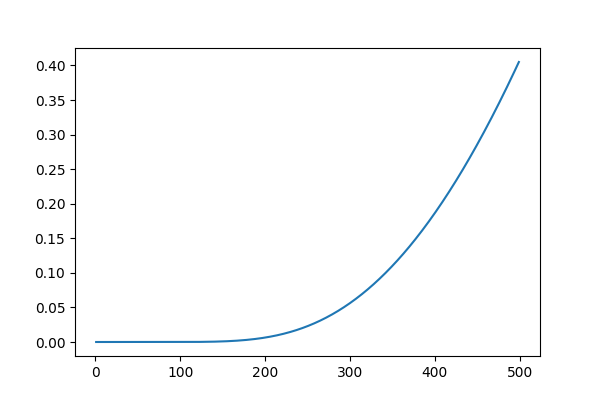

In [87]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot(thermochemical_results['T[K]'], relative_population)

<AxesSubplot:xlabel='temperature'>

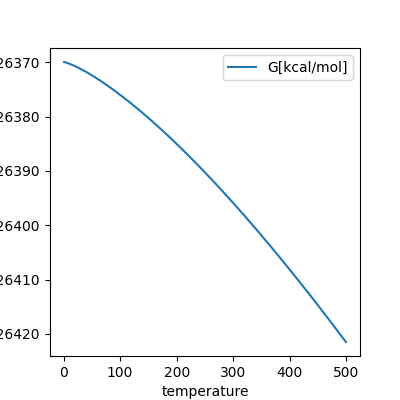

In [27]:
# thermochemical_results['w4s4.out'].plot(x='temperature', y=['H[kcal/mol]', 'S[kcal/mol/K]', 'G[kcal/mol]'], figsize=(10, 10))
thermochemical_results['w4s4.out'].plot(x='temperature', y=['G[kcal/mol]'], figsize=(4, 4), )